# Classification with One Layer MLP

You will build a neural network with one hidden layer.

**Goals:**
- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function 
- Compute the cross entropy loss 
- Implement forward and backward propagation


Let's first import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.

In [ ]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

np.random.seed(1) # set a seed so that the results are consistent

## 1 - Dataset ##

The following code will generate a "flower" 2-class dataset into variables `X` and `Y`.

In [ ]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y
    
X, Y = load_planar_dataset()

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. 

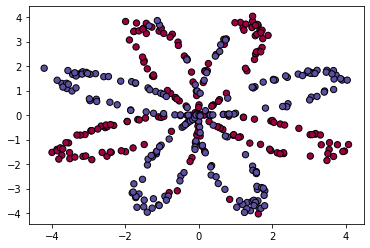

In [ ]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral, edgecolors='k');

You have:
* a numpy-array (matrix) X that contains your features (x1, x2)
* a numpy-array (vector) Y that contains your labels (red:0 or blue:1).

Lets first get a better sense of what our data is like. 

**Exercise**: How many training examples do you have? In addition, what is the `shape` of the variables `X` and `Y`? 

In [ ]:
### START CODE HERE ###
shape_X = None
shape_Y = None
m = None  # training set size
### END CODE HERE ###

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


## 2 - Simple Logistic Regression

Before building a full neural network, lets first see how logistic regression performs on this problem. You can use sklearn's built-in functions to do that. Run the code below to train a logistic regression classifier on the dataset.

In [ ]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


You can now plot the decision boundary of these models. Run the code below.

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


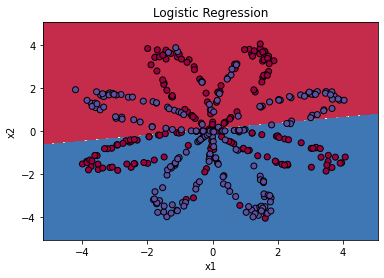

In [ ]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral, edgecolors='k')

# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now! 

## 3 - Neural Network model

Now we are going to train a Neural Network with a single hidden layer.

**Here is our model**:
<img src="https://github.com/gemaatienza/Deep-Learning-Coursera/raw/691374a31a373841bd3cad8cfa96fbef0b04a3dc/1.%20Neural%20Networks%20and%20Deep%20Learning/images/classification_kiank.png">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ (cross-entropy loss) as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**The general methodology to build a Neural Network is to**:
* Define the neural network structure ( # of input units,  # of hidden units, etc). 
* Initialize the model's parameters
* Loop:
  - Implement forward propagation
  - Compute loss
  - Implement backward propagation to get the gradients
  - Update parameters (gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

### 3.1 - Defining the neural network structure ####

**Exercise**: Define three variables:
* n_x: the size of the input layer
* n_h: the size of the hidden layer (set this to 4) 
* n_y: the size of the output layer

Use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [ ]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ###
    n_x = None # size of input layer
    n_h = 4
    n_y = None # size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [ ]:
(n_x, n_h, n_y) = layer_sizes(X, Y)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1


### 3.2 - Initialize the model's parameters ####

**Exercise**: Implement the function `initialize_parameters()`.

- Make sure your parameters' sizes are right. Refer to the figure above.
- Initialize the weights matrices with random values. 
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape (a,b).
- You will initialize the bias vectors as zeros. 
    - Use: `np.zeros((a,b))` to initialize a matrix of shape (a,b) with zeros.

In [ ]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that the output matches the solution although the initialization is random.
    print("The size of the input layer is: n_x = " + str(n_x))
    print("The size of the hidden layer is: n_h = " + str(n_h))
    print("The size of the output layer is: n_y = " + str(n_y))


    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = None
    b1 = None
    W2 = None
    b2 = None
    ### END CODE HERE ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [ ]:
n_x, n_h, n_y = 2, 4, 1

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1
W1 = [[0.00435995 0.00025926]
 [0.00549662 0.00435322]
 [0.00420368 0.00330335]
 [0.00204649 0.00619271]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[0.00299655 0.00266827 0.00621134 0.00529142]]
b2 = [[0.]]


### 3.3 - The Loop ####

**Exercise**: Implement `forward_propagation()`.

- Use the function `sigmoid()`.
- You can use the function `np.tanh()`. It is part of the numpy library.
- Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
- Implement forward propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.

In [ ]:
def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments: x -- A scalar or numpy array of any size.
    Return: s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### 
    W1 = None
    b1 = None
    W2 = None
    b2 = None
    ### END CODE HERE ###
    
    # Implement forward propagation to calculate A2 (probabilities)
    ### START CODE HERE ### 
    Z1 = None
    A1 = None
    Z2 = None
    A2 = None
    ### END CODE HERE ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

Test the function on sample data.

In [ ]:
def forward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    b1 = np.random.randn(4,1)
    b2 = np.array([[ -1.3]])

    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': b1,
     'b2': b2}

    return X_assess, parameters

X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.26281864019752443 0.09199904522700113 -1.3076660128732143 0.21287768171914198


Now that you have computed $A^{[2]}$, which contains $a^{[2](i)}$ for every example, you can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Exercise**: Implement `compute_cost()` to compute the value of the cost $J$.

Use either `np.multiply()` and then `np.sum()` or directly `np.dot()`.


In [ ]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    ### START CODE HERE ###
    logprobs = None
    cost = None
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

Test the function on sample data.

In [ ]:
def compute_cost_test_case():
    np.random.seed(1)
    Y_assess = (np.random.randn(1, 3) > 0)
    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
     'b2': np.array([[ 0.]])}

    a2 = (np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]))
    
    return a2, Y_assess, parameters
    
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6930587610394646


Using the cache computed during forward propagation, you can now implement backward propagation.

**Exercise**: Implement the function `backward_propagation()`.

Backpropagation is usually the hardest (most mathematical) part in deep learning. Build a vectorized implementation.

<img src="https://github.com/gemaatienza/Deep-Learning-Coursera/raw/691374a31a373841bd3cad8cfa96fbef0b04a3dc/1.%20Neural%20Networks%20and%20Deep%20Learning/images/grad_summary.png">

To compute $dZ1$ you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [ ]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ###
    W1 = None
    W2 = None
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ###
    A1 = None
    A2 = None
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (6 equations on slide above)
    dZ2 = None
    dW2 = None
    db2 = None
    dZ1 = None
    dW1 = None
    db1 = None
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

Test the function on sample data.

In [ ]:
def backward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = (np.random.randn(1, 3) > 0)
    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
     'b2': np.array([[ 0.]])}

    cache = {'A1': np.array([[-0.00616578,  0.0020626 ,  0.00349619],
         [-0.05225116,  0.02725659, -0.02646251],
         [-0.02009721,  0.0036869 ,  0.02883756],
         [ 0.02152675, -0.01385234,  0.02599885]]),
  'A2': np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]),
  'Z1': np.array([[-0.00616586,  0.0020626 ,  0.0034962 ],
         [-0.05229879,  0.02726335, -0.02646869],
         [-0.02009991,  0.00368692,  0.02884556],
         [ 0.02153007, -0.01385322,  0.02600471]]),
  'Z2': np.array([[ 0.00092281, -0.00056678,  0.00095853]])}
    return parameters, cache, X_assess, Y_assess
    
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


**Exercise**: Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

General gradient descent rule: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging).

<img src="https://github.com/gemaatienza/Deep-Learning-Coursera/raw/691374a31a373841bd3cad8cfa96fbef0b04a3dc/1.%20Neural%20Networks%20and%20Deep%20Learning/images/sgd.gif"> <img src="https://github.com/gemaatienza/Deep-Learning-Coursera/raw/691374a31a373841bd3cad8cfa96fbef0b04a3dc/1.%20Neural%20Networks%20and%20Deep%20Learning/images/sgd_bad.gif">



In [ ]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ###
    W1 = None
    b1 = None
    W2 = None
    b2 = None
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ###
    dW1 = None
    db1 = None
    dW2 = None
    db2 = None
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### 
    W1 = None
    b1 = None
    W2 = None
    b2 = None
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

Test the function on sample data.

In [ ]:
def update_parameters_test_case():
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
 'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
 'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
 'b2': np.array([[  9.14954378e-05]])}

    grads = {'dW1': np.array([[ 0.00023322, -0.00205423],
        [ 0.00082222, -0.00700776],
        [-0.00031831,  0.0028636 ],
        [-0.00092857,  0.00809933]]),
 'dW2': np.array([[ -1.75740039e-05,   3.70231337e-03,  -1.25683095e-03,
          -2.55715317e-03]]),
 'db1': np.array([[  1.05570087e-07],
        [ -3.81814487e-06],
        [ -1.90155145e-07],
        [  5.46467802e-07]]),
 'db2': np.array([[ -1.08923140e-05]])}
    return parameters, grads
    
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


### 3.4 - Integrate parts 3.1, 3.2 and 3.3 in nn_model() ####

**Exercise**: Build your neural network model in `nn_model()`.

The neural network model has to use the previous functions in the right order.

In [ ]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### START CODE HERE ###
    parameters = None
    W1 = None
    b1 = None
    W2 = None
    b2 = None
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
         
        ### START CODE HERE ###
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = None
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = None
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = None
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = None
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

Test the function on sample data.

In [ ]:
def nn_model_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = (np.random.randn(1, 3) > 0)
    return X_assess, Y_assess
    
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1
Cost after iteration 0: 0.693175
Cost after iteration 1000: 0.000224
Cost after iteration 2000: 0.000109
Cost after iteration 3000: 0.000072
Cost after iteration 4000: 0.000054
Cost after iteration 5000: 0.000043
Cost after iteration 6000: 0.000036
Cost after iteration 7000: 0.000031
Cost after iteration 8000: 0.000027
Cost after iteration 9000: 0.000024
W1 = [[ 0.78668574 -1.44596408]
 [ 0.61841465 -1.14797067]
 [ 0.7941403  -1.45820079]
 [ 0.54249425 -1.01738417]]
b1 = [[-0.38092208]
 [-0.26640968]
 [-0.38509848]
 [-0.21499134]]
W2 = [[3.55445121 2.18356796 3.62513709 1.74485812]]
b2 = [[0.21512924]]


### 3.5 Predictions

**Exercise**: Use your model to predict by building predict().
Use forward propagation to predict results.

predictions = $y_{prediction} =$ \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}

In [ ]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### 
    A2, cache = None
    threshold=0.5
    predictions = None
    ### END CODE HERE ###
    
    return predictions

Test the function on sample data.

In [ ]:
def predict_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
     'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
     'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
     'b2': np.array([[  9.14954378e-05]])}
    return parameters, X_assess
    
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


Let's see how the model performs on a planar dataset.

The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1
Cost after iteration 0: 0.693159
Cost after iteration 1000: 0.289308
Cost after iteration 2000: 0.273860
Cost after iteration 3000: 0.238116
Cost after iteration 4000: 0.228102
Cost after iteration 5000: 0.223318
Cost after iteration 6000: 0.220193
Cost after iteration 7000: 0.217870
Cost after iteration 8000: 0.216036
Cost after iteration 9000: 0.218645


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

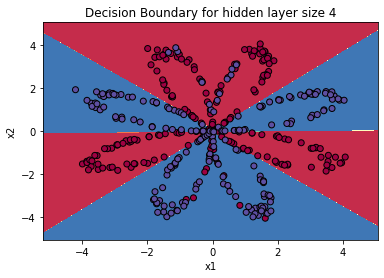

In [ ]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [ ]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


Accuracy is really high compared to Logistic Regression. The model has learnt the leaf patterns of the flower! Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression. 

Let's try out several hidden layer sizes.

### 3.6 - Tuning hidden layer size ###

Run the following code. It may take 1-2 minutes. You will observe different behaviors of the model for various hidden layer sizes.

The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 1
The size of the output layer is: n_y = 1
Accuracy for 1 hidden units: 67.5 %
The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 2
The size of the output layer is: n_y = 1
Accuracy for 2 hidden units: 67.25 %
The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 3
The size of the output layer is: n_y = 1
Accuracy for 3 hidden units: 90.75 %
The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1
Accuracy for 4 hidden units: 90.75 %
The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 5
The size of the output layer is: n_y = 1
Accuracy for 5 hidden units: 91.25 %
The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 20
The size of the output layer is: n_y = 1
Accuracy for 20 hidden units: 90.25 %
The size of the input layer is: n_x = 2
The s

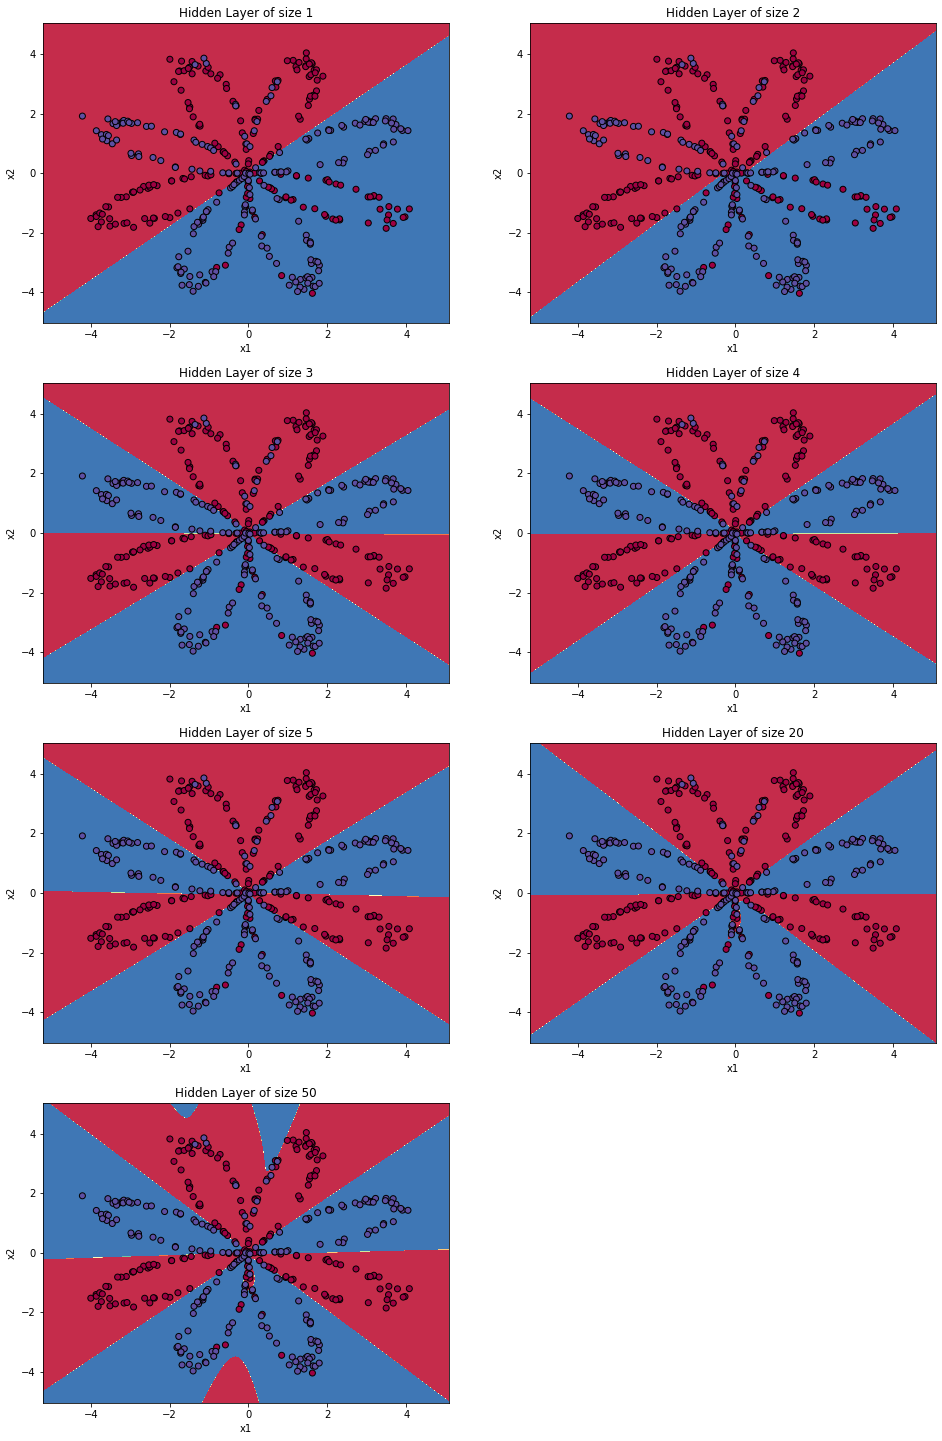

In [ ]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 10000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 

References:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/